### Import packages

In [55]:
# Common data handling libraries
import os
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 

# NLTK for test processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet

# Tensorflow for model building
import tensorflow as tf

### Load and Preprocess dataset

In [35]:
FLICKR8K_IMG_PATH = './data/Flickr8k_Dataset/'
FLICKR8K_TEXT_PATH = './data/Flickr8k_text/'
FLICKR8K_TOKEN_FILE = os.path.join(FLICKR8K_TEXT_PATH , 'Flickr8k.token.txt')
FLICKR8K_TRAIN_IMG_FILE = os.path.join(FLICKR8K_TEXT_PATH , 'Flickr_8k.trainImages.txt')
FLICKR8K_VALID_IMG_FILE = os.path.join(FLICKR8K_TEXT_PATH , 'Flickr_8k.devImages.txt')
FLICKR8K_TEST_IMG_FILE = os.path.join(FLICKR8K_TEXT_PATH , 'Flickr_8k.testImages.txt')

In [36]:
def getImageList(filename):

    sel_image_id_list = list()

    with open(filename, 'r') as file:
        data = file.read()

    for line in data.split('\n'):
        image_id = line.split('#')[0]

        if len(image_id) > 1:
            sel_image_id_list.append(os.path.join(FLICKR8K_IMG_PATH, image_id))

    sel_image_id_list = list(set(sel_image_id_list))

    return sel_image_id_list

def preprocess_caption(caption):

    # tokenize and convert to lower case
    caption = [word.lower() for word in caption.split()]

    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    # remove punctuation from each word
    caption = [word.translate(table) for word in caption]

    # remove words with numbers in them
    caption = [word for word in caption if word.isalpha()]

    # store caption as string
    caption =  ' '.join(caption)

    return caption    


def get_wordnet_pos(word):
    # Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)    


def lemmatize_caption(caption, lemmatizer, stemmer):
    stop_words = list(set(stopwords.words('english')))
    return ' '.join(list(set([stemmer.stem(lemmatizer.lemmatize(word, get_wordnet_pos(word))) 
                     for word in nltk.word_tokenize(caption)
                     if word not in stop_words])))


In [37]:
train_img_list = getImageList(filename=FLICKR8K_TRAIN_IMG_FILE)
valid_img_list = getImageList(filename=FLICKR8K_VALID_IMG_FILE)
test_img_list = getImageList(filename=FLICKR8K_TEST_IMG_FILE)

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

# to store captions and image names in lists
all_captions, all_lem_captions, all_img_names = list(), list(), list()

# read and load the annotation json file
with open(FLICKR8K_TOKEN_FILE, 'r') as file:
    data = file.read()

#iterate through each line
for line in data.split('\n'):
    #line is empty continue with next line
    if len(line) < 2:
        continue

    #split the imageid and caption sep by tab
    image_id, caption = line.split('\t')

    #strip the file extension from imageid
    image_id = image_id.split('#')[0]

    # load an image from file
    image_file_name = os.path.join(FLICKR8K_IMG_PATH, image_id)

    # get the processed caption
    caption = preprocess_caption(caption)
    # get lemmatized caption
    lem_caption = lemmatize_caption(caption, lemmatizer, stemmer)


    all_img_names.append(image_file_name)
    all_captions.append(caption)
    all_lem_captions.append(lem_caption)

img_cap_df = pd.DataFrame({'image_name':all_img_names, 
                           'caption':all_captions,
                           'caption_lem':all_lem_captions}) 

train_df = img_cap_df.loc[img_cap_df['image_name'].isin(train_img_list)].drop_duplicates('image_name')
valid_df = img_cap_df.loc[img_cap_df['image_name'].isin(valid_img_list)].drop_duplicates('image_name')
test_df = img_cap_df.loc[img_cap_df['image_name'].isin(test_img_list)].drop_duplicates('image_name')

In [38]:
print('TRAIN size:', train_df.shape)
print('VALID size:', valid_df.shape)
print('TEST size:', test_df.shape)

TRAIN size: (6000, 3)
VALID size: (1000, 3)
TEST size: (1000, 3)


In [39]:
train_df.head()

,image_name,caption,caption_lem
0,./data/Flickr8k_Dataset/1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...,way dress climb entri set pink child stair
5,./data/Flickr8k_Dataset/1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting,spot black dog fight
10,./data/Flickr8k_Dataset/1002674143_1b742ab4b8.jpg,a little girl covered in paint sits in front o...,littl paint front sit girl hand cover rainbow ...
15,./data/Flickr8k_Dataset/1003163366_44323f5815.jpg,a man lays on a bench while his dog sits by him,man sit dog bench lay
20,./data/Flickr8k_Dataset/1007129816_e794419615.jpg,a man in an orange hat starring at something,someth man hat orang star


In [40]:
top_n_attributes = 1000

freq_dist = dict(nltk.FreqDist(nltk.word_tokenize(' '.join(train_df['caption_lem'].to_list()))).most_common(top_n_attributes-1))
attrib_vocab = freq_dist.keys()

# create the tokenizer
attrib_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=',')

# fit the tokenizer on the documents
caption_attrib_list = []
for caption in train_df['caption_lem']:
    attrib_list = [word for word in caption.split() if word in attrib_vocab]
    caption_attrib_list.append(",".join(attrib_list))            

attrib_tokenizer.fit_on_texts(caption_attrib_list)

attrib_vocab_size = len(attrib_tokenizer.word_counts) + 1 

### Dataset Preparation

In [53]:
def load_image_attribute(image_name, attribute_vec):
    image = tf.io.read_file(image_name.decode('utf-8'))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299,299))
    img_tensor = tf.keras.applications.inception_v3.preprocess_input(image) 
    return img_tensor, attribute_vec

def load_image(image_name):
    image = tf.io.read_file(image_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299,299))
    img_tensor = tf.keras.applications.inception_v3.preprocess_input(image) 
    return img_tensor

def get_attribute_vector_from_caption(caption_list):
    # get the filtered words from tokenizer dictionary
    attrib_vocab = attrib_tokenizer.word_index.keys()

    # filter the caption words
    caption_attrib_list = []
    for caption in caption_list:
        attrib_list = [word for word in caption.split() if word in attrib_vocab]
        caption_attrib_list.append(",".join(attrib_list))

    attribute_vec = attrib_tokenizer.texts_to_matrix(caption_attrib_list, mode='binary')
    return attribute_vec


In [42]:
BATCH_SIZE = 100

# get the attribuites vector from the caption
train_attrib_vec = get_attribute_vector_from_caption(train_df['caption_lem'].to_list())
valid_attrib_vec = get_attribute_vector_from_caption(valid_df['caption_lem'].to_list())

# prepare train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_name'].to_list(), train_attrib_vec))
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
                                            load_image_attribute, [item1, item2], [tf.float32, tf.double]),
                                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)


# prepare valid dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_df['image_name'].to_list(), valid_attrib_vec))
valid_dataset = valid_dataset.map(lambda item1, item2: tf.numpy_function(
                                            load_image_attribute,[item1, item2], [tf.float32, tf.double]),
                                            num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


### Model Building

In [50]:
inception_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=True)
inception_model.trainable = False

model = tf.keras.layers.Dropout(0.5)(inception_model.layers[-2].output)
model = tf.keras.layers.BatchNormalization()(model)
model_output = tf.keras.layers.Dense(attrib_vocab_size, activation='sigmoid')(model)

inception_model = tf.keras.Model(inputs=inception_model.input, outputs=model_output)            

inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
inception_model.summary()   

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_378 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_378[0][0]    
____________________________________________________________________________________________

### Model Training

In [ ]:
start = time.time()
print('Training attribute extractor...')

MODEL_FILE = './data/model/attribute_extractor_model_weights.hdf5'
EPOCHS = 10

# callback initialization
callbacks = [
    tf.keras.callbacks.ModelCheckpoint( filepath=MODEL_FILE, monitor='val_loss', save_best_only=True,
                                     mode='min', save_weights_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=0.0000001, verbose=1)
]        

# train the model
history = inception_model.fit_generator(train_dataset, epochs=EPOCHS, callbacks=callbacks, validation_data=valid_dataset)

print ('Time taken to complete {} sec\n'.format(round(time.time() - start, 3)))  

# plot the history results
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(history.history['loss'], label="TrainLoss")
ax[0].plot(history.history['val_loss'], label="ValLoss")
ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], label="TrainAcc")
ax[1].plot(history.history['val_accuracy'], label="ValAcc")
ax[1].legend(loc='best', shadow=True)
plt.show()

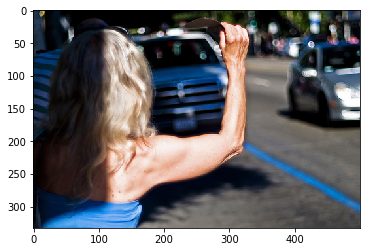

Real attributes: ride blue woman wait shirt blond appear
Predicted attributes: ['boy,girl,wear,blue,walk,red,shirt,man,stand,look']


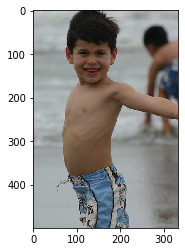

Real attributes: boy blue swim beach short
Predicted attributes: ['boy,water,short,man,blue,run,shirt,child,trunk,stand']


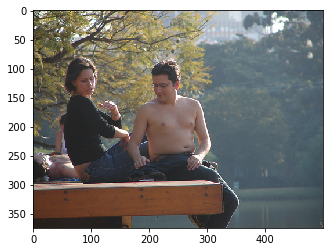

Real attributes: ladi man sit dock shirt
Predicted attributes: ['man,boy,jump,sit,bench,skateboard,woman,shirt,peopl,hold']


In [62]:
# load the model from disk
inception_model.load_weights(MODEL_FILE)

for index, row in test_df.head(3).iterrows(): 
    image_name = row['image_name']
    real_attribute = row['caption_lem']

    # load the image from numpy file in disk
    img_tensor = load_image(image_name)
    # Reshape image to include batch size from (2048) to (1, 2048)
    img_tensor = tf.expand_dims(img_tensor, 0)

    # predict on data
    pred_attribute = inception_model.predict(img_tensor)

    pred_attribute = np.argsort(pred_attribute, axis=1)
    pred_attribute = np.fliplr(pred_attribute[:,-10:])

    # iterates only once as only one row is there
    for row in pred_attribute:
        attrib_list = list()
        for col in row:
            if col == 0:
                attrib_list.append(self.PAD)
            else:
                attrib_list.append(attrib_tokenizer.index_word[col])

        pred_attribute = [",".join(attrib_list)]
        break

    # plot the image 
    plt.imshow(plt.imread(image_name))
    plt.show()
    print('Real attributes:', real_attribute)
    print('Predicted attributes:', pred_attribute)